# **Section 1:**


**Introduction to Dataset**

The dataset used in this assignment consists of email messages, including two columns: "text", labels the contents of the emails themselves, and "spam," labels them as being spam or not spam (1 and 0, respectively). Spam emails are those that advertise some product or offer to sell something and sometimes have phishing links, whilst the non-spam emails are very likely to be professional letters, personal letters, or simply enquiring about something.

The goal is to classify these emails as spam or not spam, using FastText for representation learning and Random Forest and XGBoost for classification.

FastText is a powerful word embedding method that changes text into dense numerical vectors while capturing the meaning of words and their context. This makes it well-suited for this dataset, since it works well on medium-sized datasets and can deal with noisy data, such as typos or uncommon tokens that can be present in emails.

Random Forest is ideal for the task, as it identifies non-linear patterns, reduces overfitting, and highlights features important in the data. XGBoost complements this approach by delivering high accuracy in modeling complex relationships in sparse textual data.



https://www.kaggle.com/datasets/jackksoncsie/spam-email-dataset


In [11]:
# Import necessary libraries
import pandas as pd  # For data manipulation
from gensim.utils import simple_preprocess  # For text tokenization
from sklearn.model_selection import train_test_split  # For train-test split
import numpy as np  # For handling numerical arrays
from google.colab import files  # File upload functionality

# Step 1: Upload the file
uploaded = files.upload()

# Step 2: Check if the CSV file was uploaded successfully
try:
    emails_df = pd.read_csv('emails.csv')
    print("File loaded successful")
except Exception as e:
    print(f"Error loading file: {e}")

# Step 3: Clean and preprocess the data
emails_df = emails_df.dropna()  # Remove missing values
emails_df['text'] = emails_df['text'].astype(str)  # Ensure 'text' column is string
emails_df['spam'] = emails_df['spam'].astype(int)  # Ensure 'spam' column is integer

# Step 4: Tokenize the text for FastText
emails_df['tokenized_text'] = emails_df['text'].apply(simple_preprocess)

# Step 5: Randomly sample 3,500 rows of the data
emails_sampled_df = emails_df.sample(n=3500, random_state=420).reset_index(drop=True)

# Step 6: split dataset into train and test
X_text = emails_sampled_df['text']
y_labels = emails_sampled_df['spam']
X_train_text, X_test_text, y_train, y_test = train_test_split(
    X_text, y_labels, test_size=0.2, random_state=42
)

# Step 7: Display summary of training and testing sets
print(f"Training Text Shape: {len(X_train_text)} emails")
print(f"Testing Text Shape: {len(X_test_text)} emails")
print(f"Training Labels Shape: {y_train.shape}")
print(f"Testing Labels Shape: {y_test.shape}")


Saving emails.csv to emails (2).csv
File loaded successful
Training Text Shape: 2800 emails
Testing Text Shape: 700 emails
Training Labels Shape: (2800,)
Testing Labels Shape: (700,)


# **Section 2:**

The FastText embedding approach will be used to change the textual data into numerical vectors that enable the NLP tasks such as spam classification. FastText is a word-embedding technique that captures the semantic meaning of words and subwords, making it ideal for email content understanding.

FastText works well on this dataset of 5,700 email messages as it efficiently handles small and medium-sized datasets, presenting text in a context-aware robust way. Unlike other methods for building word embeddings, FastText uses subword information which is very important when handling rare words, typos, or unique tokens typical of e-mail text. This helps the model perform better at determining spam from nonspam emails.

The preprocessing was done by tokenizing the text of each email into individual words using simple_preprocess. A FastText model was trained on the tokenized text from the training set. Each email was then represented as the average of its word embeddings, producing a fixed-length numerical vector. These vectors served as input features for the Random Forest and XGBoost classifiers.

This turned the text data into numerical features, which would let the classifiers pick up semantic patterns and improve the accuracy of spam detection.


In [12]:
# Import necessary libraries
from gensim.models import FastText
from gensim.utils import simple_preprocess
import numpy as np

# Step 1: Tokenize the training data
tokenized_train_sentences = [simple_preprocess(email) for email in X_train_text]

# Step 2: Train a FastText model using the training data
fasttext_model = FastText(
    vector_size=100,  # Dimensionality of word embeddings
    window=5,         # Context window size
    min_count=1,      # Include all words
    workers=4         # Number of threads to use
)

# Build vocabulary and train the model
fasttext_model.build_vocab(corpus_iterable=tokenized_train_sentences)
fasttext_model.train(
    corpus_iterable=tokenized_train_sentences,
    total_examples=len(tokenized_train_sentences),
    epochs=10
)

# Step 3: Represent emails as average word vectors
def get_average_vector(tokens, model):
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    if len(vectors) > 0:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(model.vector_size)

# Generate embeddings for training and testing data
X_train_features = np.array([get_average_vector(simple_preprocess(email), fasttext_model) for email in X_train_text])
X_test_features = np.array([get_average_vector(simple_preprocess(email), fasttext_model) for email in X_test_text])

# Step 4: Display feature matrix and labels
print(f"Training Feature Matrix Shape: {X_train_features.shape}")
print(f"Testing Feature Matrix Shape: {X_test_features.shape}")


Training Feature Matrix Shape: (2800, 100)
Testing Feature Matrix Shape: (700, 100)


# **Section 3:**

text 3

In [13]:
# Import necessary libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Step 1: Train the Random Forest model on the training set
rf_model = RandomForestClassifier(
    n_estimators=100,       # Number of trees in the forest
    random_state=420         # Ensures reproducibility
)
rf_model.fit(X_train_features, y_train)

# Step 2: Make predictions on the test set
y_pred_rf = rf_model.predict(X_test_features)

# Step 3: Evaluate the model
print("Random Forest Classification Report (Test Set):")
print(classification_report(y_test, y_pred_rf))
print(f"Random Forest Accuracy (Test Set): {accuracy_score(y_test, y_pred_rf):.2f}")


Random Forest Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       532
           1       0.96      0.93      0.95       168

    accuracy                           0.97       700
   macro avg       0.97      0.96      0.96       700
weighted avg       0.97      0.97      0.97       700

Random Forest Accuracy (Test Set): 0.97


In [14]:
# Import necessary libraries
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score

# Step 1: Train the XGBoost model on the training set
xgb_model = XGBClassifier(
    use_label_encoder=False,  # Avoid deprecated warnings
    eval_metric='logloss',   # Evaluation metric
    random_state=420          # Ensures reproducibility
)
xgb_model.fit(X_train_features, y_train)

# Step 2: Make predictions on the test set
y_pred_xgb = xgb_model.predict(X_test_features)

# Step 3: Evaluate the model
print("XGBoost Classification Report (Test Set):")
print(classification_report(y_test, y_pred_xgb))
print(f"XGBoost Accuracy (Test Set): {accuracy_score(y_test, y_pred_xgb):.2f}")


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:08:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       532
           1       0.94      0.98      0.96       168

    accuracy                           0.98       700
   macro avg       0.97      0.98      0.97       700
weighted avg       0.98      0.98      0.98       700

XGBoost Accuracy (Test Set): 0.98


# **Section 4:**

text 4

Performance Metrics (Test Set):
                Metric  Random Forest   XGBoost
0             Accuracy       0.974286  0.980000
1  Precision (Class 0)       0.979478  0.992395
2  Precision (Class 1)       0.957317  0.942529
3     Recall (Class 0)       0.986842  0.981203
4     Recall (Class 1)       0.934524  0.976190
5   F1-Score (Class 0)       0.983146  0.986767
6   F1-Score (Class 1)       0.945783  0.959064


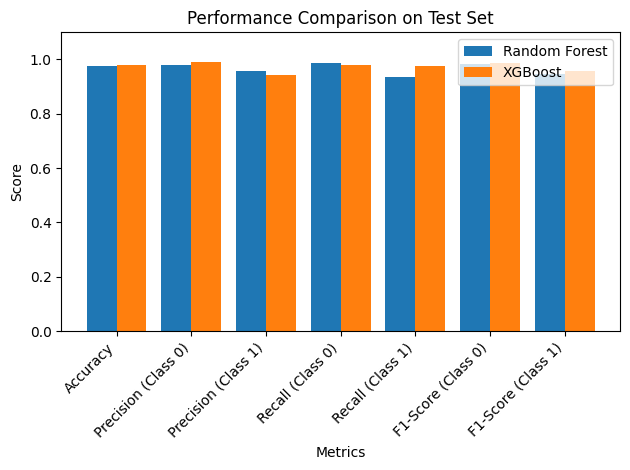

In [15]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Collect performance metrics for both models
metrics = {
    "Metric": ["Accuracy", "Precision (Class 0)", "Precision (Class 1)",
               "Recall (Class 0)", "Recall (Class 1)", "F1-Score (Class 0)", "F1-Score (Class 1)"],
    "Random Forest": [
        accuracy_score(y_test, y_pred_rf),  # Accuracy
        classification_report(y_test, y_pred_rf, output_dict=True)['0']['precision'],  # Precision (Class 0)
        classification_report(y_test, y_pred_rf, output_dict=True)['1']['precision'],  # Precision (Class 1)
        classification_report(y_test, y_pred_rf, output_dict=True)['0']['recall'],     # Recall (Class 0)
        classification_report(y_test, y_pred_rf, output_dict=True)['1']['recall'],     # Recall (Class 1)
        classification_report(y_test, y_pred_rf, output_dict=True)['0']['f1-score'],   # F1-Score (Class 0)
        classification_report(y_test, y_pred_rf, output_dict=True)['1']['f1-score']    # F1-Score (Class 1)
    ],
    "XGBoost": [
        accuracy_score(y_test, y_pred_xgb),  # Accuracy
        classification_report(y_test, y_pred_xgb, output_dict=True)['0']['precision'],  # Precision (Class 0)
        classification_report(y_test, y_pred_xgb, output_dict=True)['1']['precision'],  # Precision (Class 1)
        classification_report(y_test, y_pred_xgb, output_dict=True)['0']['recall'],     # Recall (Class 0)
        classification_report(y_test, y_pred_xgb, output_dict=True)['1']['recall'],     # Recall (Class 1)
        classification_report(y_test, y_pred_xgb, output_dict=True)['0']['f1-score'],   # F1-Score (Class 0)
        classification_report(y_test, y_pred_xgb, output_dict=True)['1']['f1-score']    # F1-Score (Class 1)
    ]
}

# Step 2: Create a DataFrame for performance metrics
metrics_df = pd.DataFrame(metrics)
print("Performance Metrics (Test Set):")
print(metrics_df)

# Step 3: Visualize the comparison between Random Forest and XGBoost
categories = metrics["Metric"]  # Extract metric categories
rf_scores = metrics_df["Random Forest"]  # Random Forest scores
xgb_scores = metrics_df["XGBoost"]       # XGBoost scores

x = range(len(categories))  # X-axis positions
plt.bar(x, rf_scores, width=0.4, label="Random Forest", align='center')  # Random Forest bar
plt.bar([p + 0.4 for p in x], xgb_scores, width=0.4, label="XGBoost", align='center')  # XGBoost bar

# Add chart labels, title, and legend
plt.xlabel("Metrics")
plt.ylabel("Score")
plt.title("Performance Comparison on Test Set")
plt.xticks([p + 0.2 for p in x], categories, rotation=45, ha='right')  # Rotate category labels
plt.ylim(0, 1.1)  # Set y-axis limits
plt.legend()
plt.tight_layout()
plt.show()
